(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic
# import tools to benchmark
import BenchmarkTools

# Import basic math
import LinearAlgebra

# Import optimization libraries
import Zygote
import JuMP
import NLopt

# Import library to perform tensor operations
using TensorOperations: @tensor

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Approximating geodesics with cubic splines

In this notebook we will explore approximating the solution to the geodesic
equation boundary condition using non-linear optimization via `JuMP.jl`.

## Simple 3D example

As a toy model to work through to gain intuition, let us define a function of
the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \alpha \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}.
$$
This function will serve as our playground to have visual intuition about the
resulting latent space geometry.

In [2]:
# Define function
f(x₁, x₂) = 10 * exp(-(x₁^2 + x₂^2))

# Define complete vector function
f̲(x) = [x[1], x[2], f(x[1], x[2])]

f̲ (generic function with 1 method)

Let's evaluate the Riemmanian metric of this function over a grid of values. For
this, we will use the `diffgeo` module from our package.

In [3]:
# Define latent space domain
range = 3

# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-range * 1.1, range * 1.1, n_range)

manifold_metric = sqrt.(
    LinearAlgebra.det.(
        [
            Antibiotic.diffgeo.riemmanian_metric(f̲, collect(x)) 
            for x in Iterators.product(z1, z2)
        ]
    )
);

Now, let's plot this quantity both on the input and output space to gain
intuition to what it represents.

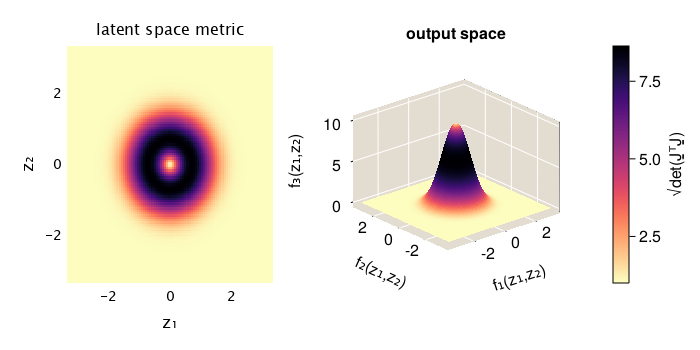

In [4]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for latent space
ax1 = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric",
)

# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add axis for latent space
ax2 = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate function on grid
f_output = hcat(vec([f̲(collect(x)) for x in Iterators.product(z1, z2)])...)

# Plot surface
surface!(
    ax2, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

# Separate axis
colgap!(gl, 50)

fig

We can see that indeed the Riemmanian metric task high values when the local map
(intrinsic geometry) is highly distorted with respect to the extrinsic geometry.

## Approximating geodesics with discretized curves

Here, we will explore different methods to get around the variational problem of
minimizing the energy functional by discretizing the curve on the manifold.
Let's begin by exploring a numerical optimization of a discretized energy
function.

### Minimizing the curve energy function

The numerical solution of boundary-value problems can be extremely tricky and
unstable when numerically solving the geodesic differential equation. Therefore,
we will approximate the energy function over a parametric curve
$\underline{\gamma}(t)$ with a set of points $\{\underline{\gamma}_k
\}_{k=1}^N$. The energy functional
$$
E[\underline{\gamma}(t)] = \frac{1}{2} \int_0^1 dt\; \left\langle
    \underline{\dot{\gamma}}(t), 
    \underline{\underline{M}}\; \underline{\dot{\gamma}}(t)
\right\rangle,
$$
is then approximated with a function $\tilde{E}$ of the form
$$
\tilde{E}(\{\underline{\gamma}_k \}) = \frac{1}{2}
\sum_{k = 2}^N
\left\langle
    \frac{\Delta \underline{\gamma}_k}{\Delta t}, 
    \underline{\underline{M_k}}
    \frac{\Delta \underline{\gamma}_k}{\Delta t}
\right\rangle \Delta t,
$$
where $\Delta t = \frac{1}{N}$ since the integration interval is from zero to 
one, $\underline{\underline{M_k}}$ is the Riemmanian metric evaluated at 
$\underline{\gamma}_k$, $\langle\cdot, \cdot\rangle$ is the inner product, and
$$
\Delta \underline{\gamma}_k = \underline{\gamma}_k - \underline{\gamma}_{k-1},
$$
such that
$$
\frac{\Delta \underline{\gamma}_k}{\Delta t} \approx 
\underline{\dot{\gamma}}(t),
$$
evaluated at $\underline{\gamma}_k$


Let's define a function to compute the energy of a discretized curve
$\{\underline{\gamma}_k\}$ on the manifold.

In [5]:
@doc raw"""
    curve_energy(Δγ̲, manifold, γ̲ₒ)

Function to compute the (discretized) integral defining the energy of a curve γ
on a Riemmanina manifold. The energy is defined as

    E = ∫ dt ⟨γ̲̇(t), M̲̲ γ̲̇(t)⟩,

where γ̲̇(t) defines the velocity of the parametric curve, and M̲̲ is the
Riemmanian metric. For this function, we use finite differences from the curve
sample points `γ` to compute this integral.

# Arguments
- `Δγ̲::AbstractVector{T}`: `d×N` long vector where `d` is the dimension of the
  manifold on which the curve lies and `N` is the number of points along the
  curve (without the initial point `γ̲ₒ`). This vector represents the differences
  between two contiguous points γ̲ₖ and `γ̲ₖ₊₁`. The longer the number of entries
  in this vector, the more accurate the energy estimate will be. NOTE: Notice
  that this function asks 
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
- `γ̲ₒ::AbstractVector{T}`: Initial position of the curve.
"""
function curve_energy(
    Δγ̲::AbstractVector{T}, manifold::Function, γ̲ₒ::AbstractVector{T}
) where T <: Real
    # Define Δt
    Δt = 1 / (length(Δγ̲) ÷ length(γ̲ₒ))

    # Reshape Δγ̲ to a matrix with each row as a dimension
    Δγ̲̲ = reshape(Δγ̲, (length(γ̲ₒ), (length(Δγ̲) ÷ length(γ̲ₒ))))

    # Reconstruct point values from initial point and Δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(Δγ̲̲, dims=2)

    # Evaluate and return energy
    return (1/(2 * Δt)) * sum(
        [
            LinearAlgebra.dot(
                Δγ̲̲[:, i], 
                Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, i]), 
                Δγ̲̲[:, i]
            )
            for i = 1:size(Δγ̲̲, 2)
        ]
    ) 
end # function

curve_energy

#### Optimization via gradient descent

Our numerical minimization routine with `JuMP.jl` requires the computation of
the gradient vector of our energy function. Automatic differentiation won't work
for our particular function. But, it can be shown that the gradient vector of
our energy $\nabla E$ has entries of the form
$$
\frac{dE}{d\Delta\gamma_k^l} = 
\frac{1}{2 \Delta t} \sum_{i=1}^d \sum_{j=1}^d
\left[
    \frac{\partial \underline{\underline{M}}_n^{i j}}{\partial \gamma_n^l} 
    \;\Delta \gamma_n^i \; \Delta \gamma_n^j +
    2 \underline{\underline{M}}_n^{l j} \; \Delta \gamma_n^j
\right].
$$

We can compute this gradient numerically with the previous work we did on
computing the derivative of the metric tensor. `JuMP.jl` requires the gradient
function to be an in-place, where the first entry is the vector where the
gradient will be stored. Let's define such function.

In [6]:
@doc raw"""
    ∇curve_energy!(∇E, Δγ̲, manifold, γ̲ₒ, out_dim)

Function that computes the gradient of the discretized energy function with
respect to the differences between the adjacent points in the curve `γ̲`.

# Arguments
- `∇E::AbstractVector{T}`: Vector where the gradient will be stored.
- `Δγ̲::AbstractVector{T}`: `d×N` long vector where `d` is the dimension of the
  manifold on which the curve lies and `N` is the number of points along the
  curve (without the initial point `γ̲ₒ`). This vector represents the differences
  between two contiguous points γ̲ₖ and `γ̲ₖ₊₁`. The longer the number of entries
  in this vector, the more accurate the energy estimate will be. NOTE: Notice
  that this function asks 
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
- `γ̲ₒ::AbstractVector{T}`: Initial position of the curve.
- `out_dim::Int`: Dimensionality of output space.
"""
function ∇curve_energy!(
    ∇E::AbstractVector{T}, 
    Δγ̲::AbstractVector{T}, 
    manifold::Function, 
    γ̲ₒ::AbstractVector{T},
    out_dim::Int,
) where T <: AbstractFloat
    # Reshape Δγ̲ to a matrix with each row as a dimension
    Δγ̲̲ = reshape(Δγ̲, length(γ̲ₒ), :)

    # Reconstruct point values from initial point and Δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(Δγ̲̲, dims=2)

    # Initialize array where to save the metric evaluated at each point
    M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 2)..., size(Δγ̲̲, 2))

    # Initialize array where to save the derivative of the metric evaluated at
    # each point.
    ∂M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 3)..., size(Δγ̲̲, 2))

    # Loop through each γ value
    for k = 1:size(Δγ̲̲, 2)
        # Compute metric
        M̲̲[:, :, k] .= Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, k])
        # Compute derivative of metric
        ∂M̲̲[:, :, :, k] .= Antibiotic.diffgeo.∂M̲̲∂γ̲(manifold, γ̲̲[:, k], out_dim)
    end # for

    # Define Δt
    Δt = 1 / (size(γ̲̲, 2) - 1)

    # Initialize array to save gradient. Note: The gradient is obviously a
    # vector, but we will store it as an array to keep track of which point
    # along the curve each entry corresponds to
    ∇E_mat = zeros(T, size(Δγ̲̲)...)
    
    # Loop through each of the entries
    for k = 1:size(γ̲̲, 2)-1
        # Extract relevant pieces
        _M̲̲ = @view M̲̲[:, :, k]
        _∂M̲̲ = @view ∂M̲̲[:, :, :, k]
        _Δγ̲ = @view Δγ̲̲[:, k]

        # Compute gradient
        @tensor ∇E_mat[:, k][l] = 1 / (2 * Δt) * (
            _∂M̲̲[i, j, l] * _Δγ̲[i] * _Δγ̲[j] +
            2 * _M̲̲[l, i] * _Δγ̲[i]
        )
    end # for
    # Update gradient vector in place
    ∇E .= ∇E_mat[:]
end # function

∇curve_energy!

With these two functions at hand, let's define a simple function that connects
the initial and final point using a straight line that we can use as an initial
guess for the geodesic.

In [7]:
@doc raw"""
    curve_init(γ_init, γ_end, n_points)

Function that returns `n_points` connecting the `γ_init` and `γ_end` points with
a straight line.

# Arguments
-`γ_init::Vector{T}`: Initial position of curve γ̲(t).
- `γ_end::Vector{T}`: Final position of curve γ̲(t).
- `n_points::Int`: Number of interpolating points

# Returns
- `Δγ̲::Vector{T}`: Differences between points connecting initial and final
  point.
"""
function curve_init(
    γ_init::Vector{T}, γ_end::Vector{T}, n_points::Int
) where T <: AbstractFloat
    # Initialize array where to return curve
    γ = Matrix{T}(undef, length(γ_init), n_points)
    # Set initial and final points
    γ[:, 1] = γ_init
    γ[:, end] = γ_end

    # Loop through dimensions
    for d = 1:length(γ_init)
        # Interpolate between points
        γ[d, 2:end-1] = LinRange(γ_init[d], γ_end[d], n_points-2)
    end # for

    return diff(γ, dims=2)[:]
end # function

curve_init

Let's test both of our functions. First, we initialize a curve.

In [8]:
# Define points to connect
γ_init = [2.0, -2.0]
γ_end = [-2.0, 1.0]

# Define number of points
n_points = 50

# Initialize curve
Δγ̲ₒ = curve_init(γ_init, γ_end, n_points);

Let's compute the energy of this initial guess.

In [9]:
curve_energy(Δγ̲ₒ, f̲, γ_init)

250.22000453278545

Let's benchmark this function.

In [10]:
BenchmarkTools.@benchmark curve_energy(Δγ̲ₒ, f̲, γ_init)

BenchmarkTools.Trial: 4468 samples with 1 evaluation.
 Range (min … max):  1.015 ms …  34.314 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.064 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.118 ms ± 981.468 μs  ┊ GC (mean ± σ):  2.25% ± 3.17%

               ▁▄▆█▆▅▂▁                                        
  ▁▁▁▂▂▂▂▂▁▁▁▂▄█████████▆▅▄▄▄▃▃▃▃▃▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.02 ms         Histogram: frequency by time        1.17 ms <

 Memory estimate: 342.42 KiB, allocs estimate: 10059.

Next, we test the gradient function.

In [11]:
# Initialize vector where to save gradient
∇E = similar(Δγ̲ₒ)

# Compute gradient
∇curve_energy!(∇E, Δγ̲ₒ, f̲, γ_init, 3)

98-element Vector{Float64}:
  0.0
  0.0
 -4.090939246102152
  3.069771740409234
 -4.101306918814746
  3.0805439858732284
 -4.127928183267795
  3.1086229816449733
 -4.192781067672359
  3.1781704733683647
  ⋮
  4.358736867047317
 -5.334437893260873
  3.6848999948420236
 -4.640289656356374
  3.34600886779539
 -4.31950073289054
  3.1853675982994303
  0.0
  0.0

The function seems to be working as well. Let's also benchmark it.

In [12]:
BenchmarkTools.@benchmark ∇curve_energy!(∇E, Δγ̲ₒ, f̲, γ_init, 3)

BenchmarkTools.Trial: 1398 samples with 1 evaluation.
 Range (min … max):  3.309 ms … 29.205 ms  ┊ GC (min … max): 0.00% … 86.24%
 Time  (median):     3.385 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.576 ms ±  1.929 ms  ┊ GC (mean ± σ):  4.27% ±  6.92%

  ▄▇▇▆▆▄▇█▆▃▂                          ▁▂▁ ▁                 ▁
  █████████████▆▇▅▅▅▆▁▅▄▅▁▄▁▄▅▄▆▆▅▇▆▅▆▇█████▇▇█▆▇▆▆▆▄▅▅▁▆▄▅▇ █
  3.31 ms      Histogram: log(frequency) by time     3.98 ms <

 Memory estimate: 1.83 MiB, allocs estimate: 34738.

### Optimizing curve with `JuMP.jl`

Having defined the energy function as the objective function to be minimized and
the gradient of the energy to update the set of $\{\Delta\gamma_k \}$ values,
let's use `JuMP.jl` for this non-linear constrained optimization. For this, we
must register our function to be used with the optimization algorithms in the
package.  The arguments to register are:

1. The model for which the functions are registered.
2. A Julia symbol object which serves as the name of the user-defined function
   in JuMP expressions.
3. The number of input arguments that the function takes.
4. The Julia method which computes the function
5. A flag to instruct JuMP to compute exact gradients automatically.

We begin by defining function `E` and `∇E` as anonymous functions with our
specific manifold and initial conditions "burned in" so that we do not have to
specify this parameters. Furthermore, for user-defined functions, `JuMP.jl`
cannot take arrays as input. Each parameter has to be given independently. Thus,
our functions will take as input the curve evaluations independently.

In [13]:
# Define energy function with fixed manifold
Energy(Δγ̲::T...) where T <: AbstractFloat = curve_energy(collect(Δγ̲), f̲, γ_init)
# Define gradient of function with fixed manifold
∂̲Energy!(∇E::AbstractVector{T}, Δγ̲::T...) where T <: AbstractFloat = 
    ∇curve_energy!(∇E, collect(Δγ̲), f̲, γ_init, 3)

∂̲Energy! (generic function with 1 method)

Next, let's define the optimization algorithm. For our case, we will use the
`NLopt.jl` package with the `:LD_SLSQP` algorithm for local gradient-based
optimization.

In [14]:
# Initialize a JuMP model
model = JuMP.Model(NLopt.Optimizer)

# Set optimizer algorithm
JuMP.set_optimizer_attribute(model, "algorithm", :LD_SLSQP)

# Set attributes
JuMP.set_attributes(model, "tol" => 1e-6, "max_iter" => 1_000)
JuMP.set_optimizer_attributes(model, "tol" => 1e-6, "max_iter" => 1_000)

model

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: NLopt

Now, we register our model using `JuMP.register`. We feed the previously defined
model, add a symbol (`:energy`) to name the registered model, the number of
parameters that our model takes as input, and the objective function along with
the gradient for the optimization. Notice that we set `autodiff=false` as well
since we do not want automatic differentiation to try to compute the Hessian of
our function.

In [15]:
# Register model
JuMP.register(model, :energy, length(Δγ̲ₒ), Energy, ∂̲Energy!; autodiff=false)

Having registered the model, we need to define the internal variables that
`JuMP.jl` will optimize over. These are not regular `Julia` variables that
associate an object with a value, but `JuMP`'s own internal representations of
the parameters to be optimized over. In our case, we must define one variable
for each of the finite differences in our curve. In this case, we will name the
`JuMP.jl` variables `Δγ`.

In [16]:
# Register variables
JuMP.@variable(model, Δγ[1:length(Δγ̲ₒ)])

98-element Vector{JuMP.VariableRef}:
 Δγ[1]
 Δγ[2]
 Δγ[3]
 Δγ[4]
 Δγ[5]
 Δγ[6]
 Δγ[7]
 Δγ[8]
 Δγ[9]
 Δγ[10]
 ⋮
 Δγ[90]
 Δγ[91]
 Δγ[92]
 Δγ[93]
 Δγ[94]
 Δγ[95]
 Δγ[96]
 Δγ[97]
 Δγ[98]

Now, we define the constraints on the optimization. For our case, since we want
the initial point $\underline{\gamma}_1$ and the final point
$\underline{\gamma}_N$ to be connected, it must be the case that
$$
\sum_{i=2}^N \Delta \underline{\gamma}_i =
\underline{\gamma}_N - \underline{\gamma}_1 .
$$
But this constraint must be satisfied per each dimension, thus, we define one
constraint per latent space dimension of the form
$$
\sum_{i=2}^N \Delta \gamma_i^j = \gamma_N^j - \gamma_1^j .
$$

In [17]:
# Define dimensionality of latent space
d = length(γ_init)

# Set linear constraints for each dimension
# JuMP.@constraint(model, c[i=1:d], sum(Δγ[i:d:end]) == (γ_end .- γ_init)[i])

JuMP.@NLconstraint(
    model, 
    c[i=1:d], 
    sum(Δγ[j] for j = i:d:length(Δγ̲ₒ)) == (γ_end .- γ_init)[i]
)

2-element Vector{JuMP.NonlinearConstraintRef{JuMP.ScalarShape}}:
 (Δγ[1] + Δγ[3] + Δγ[5] + Δγ[7] + Δγ[9] + Δγ[11] + Δγ[13] + Δγ[15] + Δγ[17] + Δγ[19] + Δγ[21] + Δγ[23] + Δγ[25] + Δγ[27] + Δγ[29] + Δγ[31] + Δγ[33] + Δγ[35] + Δγ[37] + Δγ[39] + Δγ[41] + Δγ[43] + Δγ[45] + Δγ[47] + Δγ[49] + Δγ[51] + Δγ[53] + Δγ[55] + Δγ[57] + Δγ[59] + Δγ[61] + Δγ[63] + Δγ[65] + Δγ[67] + Δγ[69] + Δγ[71] + Δγ[73] + Δγ[75] + Δγ[77] + Δγ[79] + Δγ[81] + Δγ[83] + Δγ[85] + Δγ[87] + Δγ[89] + Δγ[91] + Δγ[93] + Δγ[95] + Δγ[97]) - -4.0 = 0
 (Δγ[2] + Δγ[4] + Δγ[6] + Δγ[8] + Δγ[10] + Δγ[12] + Δγ[14] + Δγ[16] + Δγ[18] + Δγ[20] + Δγ[22] + Δγ[24] + Δγ[26] + Δγ[28] + Δγ[30] + Δγ[32] + Δγ[34] + Δγ[36] + Δγ[38] + Δγ[40] + Δγ[42] + Δγ[44] + Δγ[46] + Δγ[48] + Δγ[50] + Δγ[52] + Δγ[54] + Δγ[56] + Δγ[58] + Δγ[60] + Δγ[62] + Δγ[64] + Δγ[66] + Δγ[68] + Δγ[70] + Δγ[72] + Δγ[74] + Δγ[76] + Δγ[78] + Δγ[80] + Δγ[82] + Δγ[84] + Δγ[86] + Δγ[88] + Δγ[90] + Δγ[92] + Δγ[94] + Δγ[96] + Δγ[98]) - 3.0 = 0

Let's set the initial values of each of the variables as the line connecting the
initial and the final point. Later, we will look more into how to improve this
initial guess.

In [18]:
# Loop through variables
for (i, Δ) in enumerate(Δγ̲ₒ)
    # Set initial value for variable.
    JuMP.set_start_value(Δγ[i], Δ)
end # for

Finally, we define the objective of minimizing the energy function. This is a
non-linear optimization routine, therefore, we use the `@NLobjective` function
to define the minimization of our `:energy` model.

In [19]:
# Set objective
JuMP.@NLobjective(model, Min, energy(Δγ...))

Now, we are ready to run the optimization! We simply run the `optimize!`
function on our model.

In [20]:
# Run optimization
JuMP.optimize!(model)

# Print a summary of the solution
JuMP.solution_summary(model)

* Solver : NLopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "FTOL_REACHED"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 6.74546e+01
  Dual objective value : 0.00000e+00

* Work counters
  Solve time (sec)   : 7.97159e-01


Let's compare the initial energy for the straight line and the final curve.

In [21]:
println("Initial energy: $(Energy(Δγ̲ₒ...))")

println("Optimized energy: $(JuMP.objective_value(model))")

Initial energy: 250.22000453278545
Optimized energy: 67.45463370535546


There is definitely a reduction in the energy! Let's look at the solution. To
get the optimized values of the curve, we use the `JuMP.value` function on each
of the variables we declared. But, recall this only gives us the finite
differences between adjacent points. Therefore, we can use `cumsum` to obtain
the true values.

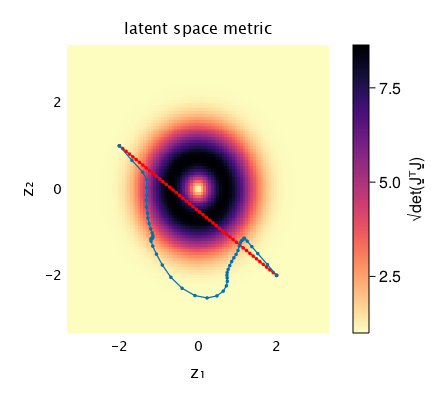

In [22]:
# Construct initial curve from finite differences
γₒ = hcat(γ_init, γ_init .+ cumsum(reshape(Δγ̲ₒ, 2, :), dims=2))
# Construct solution from differences
γ = hcat(γ_init, γ_init .+  cumsum(reshape(JuMP.value.(Δγ), 2, :), dims=2))

# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add initial guess
scatterlines!(ax_input, eachrow(γₒ)..., markersize=5, color=:red)

# Add optimized curve
scatterlines!(ax_input, eachrow(γ)..., markersize=5)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig

The curve is not following the expected geodesic. It might require a better
guess for the initial condition.

## Minimizing the curve length

Although the traditional method is to minimize the curve energy, the definition
of a geodesic is such that minimizes the length of the path between two curves.
The length functional is of the form
$$
L[\underline{\gamma}(t)] = \int_0^1 dt\; \sqrt{
    \left\langle
    \underline{\dot{\gamma}}(t), 
    \underline{\underline{M}}\; \underline{\dot{\gamma}}(t)
\right\rangle
}
$$
With a discrete curve, we can write a function $\tilde{L}$
$$
L\left(\left\{\underline{r}_k\right\}\right) =
\sum_{k=1}^N \Delta t
\left[\left\langle
    \frac{\Delta \underline{\gamma}_k}{\Delta t},
    \underline{\underline{M_k}} \frac{\Delta \underline{r}_k}{\Delta t}
\right\rangle\right]^{1 / 2}.
$$
Let's define a function that computes this length from a discrete set of sample
points along the curve.

In [23]:
@doc raw"""
    curve_length(Δγ̲, manifold, γ̲ₒ)

Function to compute the (discretized) integral defining the length of a curve γ
on a Riemmanina manifold. The energy is defined as

    L = ∫ dt √(⟨γ̲̇(t), M̲̲ γ̲̇(t)⟩),

where γ̲̇(t) defines the velocity of the parametric curve, and M̲̲ is the
Riemmanian metric. For this function, we use finite differences from the curve
sample points `γ` to compute this integral.

# Arguments
- `Δγ̲::AbstractVector{T}`: `d×N` long vector where `d` is the dimension of the
  manifold on which the curve lies and `N` is the number of points along the
  curve (without the initial point `γ̲ₒ`). This vector represents the differences
  between two contiguous points γ̲ₖ and `γ̲ₖ₊₁`. The longer the number of entries
  in this vector, the more accurate the energy estimate will be. NOTE: Notice
  that this function asks 
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
- `γ̲ₒ::AbstractVector{T}`: Initial position of the curve.
"""
function curve_length(
    Δγ̲::AbstractVector{T}, manifold::Function, γ̲ₒ::AbstractVector{T}
) where T <: Real
    # Define Δt
    Δt = 1 / (length(Δγ̲) ÷ length(γ̲ₒ))

    # Reshape Δγ̲ to a matrix with each row as a dimension
    Δγ̲̲ = reshape(Δγ̲, (length(γ̲ₒ), (length(Δγ̲) ÷ length(γ̲ₒ))))

    # Reconstruct point values from initial point and Δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(Δγ̲̲, dims=2)

    # Evaluate and return energy
    return sum(
        [
            sqrt(
                LinearAlgebra.dot(
                    Δγ̲̲[:, i], 
                    Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, i]), 
                    Δγ̲̲[:, i]
                )
            )
            for i = 1:size(Δγ̲̲, 2)
        ]
    ) 
end # function

curve_length

Let's compute the length on the original straight curve and the optimized curve.
Notice that although the straight curve is shorter in latent space, it should
give a longer length given that the space is non-Euclidean.

In [24]:
println("Initial length: $(curve_length(Δγ̲ₒ, f̲, γ_init))")

println("Optimized length: $(curve_length(JuMP.value.(Δγ), f̲, γ_init))")

Initial length: 18.50612479748772
Optimized length: 9.483462704712354


#### Length function gradient descent

As expected, the optimized curve is shorter on the manifold. But visually we can
see it is not as short as possible. Let's define the gradient of the length
function to optimize it directly. The gradient for the length is of the form
$$
\frac{\partial L}{\partial \Delta\gamma_n^l} =
\frac{
    \frac{1}{2} \sum_i^d \sum_j^d
    \left[
        \frac{\partial M_n^{i j}}{\partial \gamma_n^l} 
        \Delta \gamma_n^i \Delta \gamma_n^j +
        2 M_n^{l j} \Delta \gamma_n^j
    \right]
}{
    \left[
        \sum_{i=1}^1 \sum_{j=1}^j M_n^{i j} 
        \Delta \gamma_n^i \Delta \gamma_n^j
    \right]^{1 / 2}
}.
$$
Let's define the function that computes this gradient.

In [25]:
@doc raw"""
    ∇curve_length!(∇L, Δγ̲, manifold, γ̲ₒ, out_dim)

Function that computes the gradient of the discretized length function with
respect to the differences between the adjacent points in the curve `γ̲`.

# Arguments
- `∇L::AbstractVector{T}`: Vector where the gradient will be stored.
- `Δγ̲::AbstractVector{T}`: `d×N` long vector where `d` is the dimension of the
  manifold on which the curve lies and `N` is the number of points along the
  curve (without the initial point `γ̲ₒ`). This vector represents the differences
  between two contiguous points γ̲ₖ and `γ̲ₖ₊₁`. The longer the number of entries
  in this vector, the more accurate the length estimate will be. NOTE: Notice
  that this function asks 
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
- `γ̲ₒ::AbstractVector{T}`: Initial position of the curve.
- `out_dim::Int`: Dimensionality of output space.
"""
function ∇curve_length!(
    ∇L::AbstractVector{T}, 
    Δγ̲::AbstractVector{T}, 
    manifold::Function, 
    γ̲ₒ::AbstractVector{T},
    out_dim::Int,
) where T <: AbstractFloat
    # Reshape Δγ̲ to a matrix with each row as a dimension
    Δγ̲̲ = reshape(Δγ̲, length(γ̲ₒ), :)

    # Reconstruct point values from initial point and Δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(Δγ̲̲, dims=2)

    # Initialize array where to save the metric evaluated at each point
    M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 2)..., size(Δγ̲̲, 2))
    # Initialize array where to save the inner product
    γMγ = Vector{T}(undef, size(Δγ̲̲, 2))

    # Initialize array where to save the derivative of the metric evaluated at
    # each point.
    ∂M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 3)..., size(Δγ̲̲, 2))

    # Loop through each γ value
    for k = 1:size(Δγ̲̲, 2)
        # Compute metric
        M̲̲[:, :, k] .= Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, k])
        # Compute derivative of metric
        ∂M̲̲[:, :, :, k] .= Antibiotic.diffgeo.∂M̲̲∂γ̲(manifold, γ̲̲[:, k], out_dim)
        # Compute inner product
        γMγ[k] = LinearAlgebra.dot(Δγ̲̲[:, k], M̲̲[:, :, k],Δγ̲̲[:, k]) + eps()
    end # for

    # Define Δt
    Δt = 1 / (size(γ̲̲, 2) - 1)

    # Initialize array to save gradient. Note: The gradient is obviously a
    # vector, but we will store it as an array to keep track of which point
    # along the curve each entry corresponds to
    ∇L_mat = zeros(T, size(Δγ̲̲)...)
    
    # Loop through each of the entries
    for k = 1:size(γ̲̲, 2)-1
        # Extract relevant pieces
        _M̲̲ = @view M̲̲[:, :, k]
        _∂M̲̲ = @view ∂M̲̲[:, :, :, k]
        _Δγ̲ = @view Δγ̲̲[:, k]
        gMg = @view γMγ[k]

        # Compute gradient
        @tensor ∇L_mat[:, k][l] = 1 / 2 / √(first(gMg))  * (
            _∂M̲̲[i, j, l] * _Δγ̲[i] * _Δγ̲[j] +
            2 * _M̲̲[l, i] * _Δγ̲[i]
        )
    end # for
    # Update gradient vector in place
    ∇L .= ∇L_mat[:]
end # function

∇curve_length!

Let's test the function

In [26]:
# Initialize vector where to save gradient
∇L = similar(Δγ̲ₒ)

# Compute gradient
∇curve_length!(∇L, Δγ̲ₒ, f̲, γ_init, 3)

98-element Vector{Float64}:
  0.0
  0.0
 -0.8007215573533997
  0.6008479375590708
 -0.8019774548549667
  0.6023755047508988
 -0.805146847528235
  0.6063327370787495
 -0.8126976531139092
  0.6160330442286354
  ⋮
  0.6243528502785385
 -0.8748044749005516
  0.6042936612161581
 -0.8300831197999521
  0.5985543329290377
 -0.8110111495170881
  0.5980711191597735
  0.0
  0.0

Let's now set the equivalent optimization routine with `JuMP.jl`, this time
optimizing the length function with its corresponding gradient.

In [27]:
# Define length function with fixed manifold
Len(Δγ̲::T...) where T <: AbstractFloat = curve_length(collect(Δγ̲), f̲, γ_init)
# Define gradient of function with fixed manifold
∂̲Len!(∇E::AbstractVector{T}, Δγ̲::T...) where T <: AbstractFloat = 
    ∇curve_length!(∇E, collect(Δγ̲), f̲, γ_init, 3)

# Initialize a JuMP model
model = JuMP.Model(NLopt.Optimizer)

# Set optimizer algorithm
JuMP.set_optimizer_attribute(model, "algorithm", :LD_SLSQP)

# Set attributes
JuMP.set_attributes(model, "tol" => 1e-6, "max_iter" => 1_000)
JuMP.set_optimizer_attributes(model, "tol" => 1e-6, "max_iter" => 1_000)

# Register model
JuMP.register(model, :len, length(Δγ̲ₒ), Len, ∂̲Len!; autodiff=false)

# Register variables
JuMP.@variable(model, Δγ[1:length(Δγ̲ₒ)])

# Define dimensionality of latent space
d = length(γ_init)

# Set linear constraints for each dimension
JuMP.@constraint(model, c[i=1:d], sum(Δγ[i:d:end]) == (γ_end .- γ_init)[i])

# Loop through variables
for (i, Δ) in enumerate(Δγ̲ₒ)
    # Set initial value for variable.
    JuMP.set_start_value(Δγ[i], Δ)
end # for

# Set objective
JuMP.@NLobjective(model, Min, len(Δγ...))

We can now optimize the model.

In [28]:
# Run optimization
JuMP.optimize!(model)

# Print a summary of the solution
JuMP.solution_summary(model)

* Solver : NLopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "FTOL_REACHED"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 1.13941e+01

* Work counters
  Solve time (sec)   : 5.87359e+00


Let's the curve lengths

In [29]:
println("Initial Length: $(Len(Δγ̲ₒ...))")

println("Optimized energy: $(JuMP.objective_value(model))")

Initial Length: 18.50612479748772
Optimized energy: 11.3940623211014


Even shorter than before! This looks really promising. Let's look at the
resulting curves.

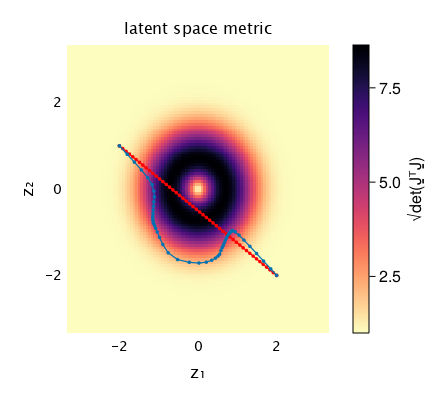

In [30]:
# Construct initial curve from finite differences
γₒ = hcat(γ_init, γ_init .+ cumsum(reshape(Δγ̲ₒ, 2, :), dims=2))
# Construct solution from differences
γ = hcat(γ_init, γ_init .+  cumsum(reshape(JuMP.value.(Δγ), 2, :), dims=2))

# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add initial guess
scatterlines!(ax_input, eachrow(γₒ)..., markersize=5, color=:red)

# Add optimized curve
scatterlines!(ax_input, eachrow(γ)..., markersize=5)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig

this is not right. It seems that since we do not have a constraint on having the
points roughly evenly spaced, the optimization routine found it easier to
conglomerate all points near to the origin and pay only the prize of having one
long distance, where the metric is not evaluated in between. This is definitely
not working.

## Energy-Minimizing Splines

As another alternative, we will follow the algorithm proposed by [Hofer &
Pottmann](https://dl.acm.org/doi/abs/10.1145/1186562.1015716?casa_token=W17tL07QVMYAAAAA:316pcdrXjbKI_P19079dXqtwOb34b-ag2sD0il-SykfWnoBdxEQaFc4xEdW-y-qrdy070g_DhF-4DA).
These authors come from the computer graphics world, where paths through 3D
meshes are relevant for their modeling. Therefore, they propose a
geometrically-motivated algorithm to fit splines on manifolds.

`[add explanation of algorithm here]`

To test the algorithm, we will begin with the minimization of the curve energy
in the output space, this is
$$
E[\underline{x}(t)] = \int_0^1 dt \; 
\langle \underline{x}(t), \underline{\underline{Q}} \underline{x}(t) \rangle,
$$
where $\underline{x}(t)$ is the curve on the output space⸺in contrast to
$\underline{\gamma}(t)$ the curve living on the input space⸺and
$\underline{\underline{Q}}$ is the metric in Euclidean space⸺in contrast to 
the Riemmanian metric $\underline{\underline{M}}$. Just as we did when
considering the curve $\underline{\gamma}(t)$ on the Riemmanian manifold, we can
discretize this functional and write a function of the form
$$
\tilde{E}(\{\underline{x}_k \}) = \frac{1}{2}
\sum_{k = 2}^N
\left\langle
    \frac{\Delta \underline{x}_k}{\Delta t}, 
    \underline{\underline{Q_k}}
    \frac{\Delta \underline{x}_k}{\Delta t}
\right\rangle \Delta t,
$$

The algorithm requires us to find the point $\tilde{E}(\{\underline{x}_k^*\})$
that minimizes this functional without the constraint of the points
$\{\underline{x}_k^* \}$ being on the manifold. For a curve connecting two
points $\underline{x}(0)$ and $\underline{x}(1)$⸺parametrized in the input space
by points $\underline{\gamma}(0)$ and $\underline{\gamma}(1)$⸺the path that
minimizes the distance is a straight line on the output space. Thus, the set of
points $\{\underline{x}_k^* \}$ are simply the set of points connecting
$\underline{x}(0)$ and $\underline{x}(1)$ via a straight line, ignoring the
manifold. The algorithm then iteratively takes small steps along this "optimal"
path, and projects them back to the Manifold so that they satisfy the constraint
of lying on the manifold.

The steps of the algorithm can be listed as follows:

1. Map the current point along the curve $\underline{\gamma}_k$ to the output
   space to obtain $\underline{x}_k$. Obviously, the in the first iteration,
   this will result in $\underline{x}_1$.
2. Generate the basis vectors that define the tangent space at
   $\underline{x}_1$. To gain intuition, think of a 2D surface for our
   Riemmanian manifold. The tangent space is defined by a set of basis vectors
   $\{\underline{c}_1, \underline{c}_2 \}$ that define a tangent plane that
   barely "kisses" the surface at point $\underline{x}_1$. For the case of a
   parametric Riemmanian manifold as we have, these basis vectors are defined by
   the derivatives of the map $\underline{f}$ with respect to the curve
   parameters $\underline{\gamma}(t)$. But these derivatives are exactly what
   the Jacobian is. Thus, the columns of the Jacobian define the basis vectors
   for the tangent space.
3. Compute the Riemmanian metric $\underline{\underline{M}}$ at point
   $\underline{\gamma}_k$.
4. Compute the vector $\underline{r}_k$ where each of the entries $r_i$ are
   defined by the inner product
$$
r_k^{(j)} = \left\langle 
    \underline{x}(1) - \underline{x}_k, \underline{c}_j 
\right\rangle.
$$
In words, we define the vector pointing from the current position
$\underline{x}_k$ to the desired final point on the curve $\underline{x}(1)$ and 
take the inner product of that vector with the different basis vectors defining 
the tangent space at $\underline{x}_k$.
5. Solve the linear system
$$
\underline{\underline{M}}\; \underline{v}_k = \underline{r}_k.
$$
6. Update the curve parameters $\underline{\gamma}_k$ as
$$
\underline{\gamma}_{k + 1} = \underline{\gamma}_k + s \underline{v}_k,
$$
where $s$ is the step size chosen to update the parameters.

Let's define a function that performs this algorithm. We will add an early stop
sign in case the number of chosen points is too large.

In [31]:
@doc raw"""
    min_energy_spline(γ_init, γ_end, manifold, n_points; step_size, stop, tol)

Function that produces an energy-minimizing spline between two points `γ_init`
and `γ_end` on a Riemmanian manifold using the algorithm by Hoffer & Pottmann.

# Arguments
- `γ_init::AbstractVector{T}`: Initial position of curve `γ` on the parameter
  space.
- `γ_end::AbstractVector{T}`: Final position of curve `γ` on the parameter
  space.
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
- `n_points::Int`: Number of points to use for the interpolation.

## Optional arguments
- `step_size::AbstractFloat=1E-3`: Step size used to update curve parameters.
- `stop::Boolean=true`: Boolean indicating if iterations should stop if the
  current point is within certain tolerance value `tol` from the desired final
  point.
- `tol::AbstractFloat=1E-6`: Tolerated difference between desired and current
  final point for an early stop criteria.

# Returns
- `γ::Matrix{T}`: `d × N` matrix where each row represents each of the
  dimensions on the manifold and `N` is the number of points needed to
  interpolate between points.

where `T <: AbstractFloat`
"""
function min_energy_spline(
    γ_init::AbstractVector{T}, 
    γ_end::AbstractVector{T}, 
    manifold::Function, 
    n_points::Int; 
    step_size::AbstractFloat=1E-3, 
    stop::Bool=true, 
    tol::AbstractFloat=1E-3,
) where T <: AbstractFloat
    # Initialize matrix where to store interpolation points
    γ = Matrix{T}(undef, length(γ_init), n_points)
    # Set initial value
    γ[:, 1] .= γ_init

    # Map final position to output space
    x_end = manifold(γ_end)

    # Initialize loop counter
    count = 1
    # Loop through points
    for i = 2:n_points
        # 1. Map current point to output space
        x_current = manifold(γ[:, i-1])
        # 2. Compute Jacobian. Each column represents one basis vector c̲ for
        #    the tangent space at x_current.
        J̲̲ = first(Zygote.jacobian(manifold, γ[:, i-1]))
        # 3. Compute the Riemmanian metric tensor at current point
        M̲̲ = J̲̲' * J̲̲
        # 4. Compute the difference between the current position and the desired
        #    final point
        Δx̲ = x_end .- x_current
        # 5. Compute r̲ vector where each entry is the inner product beetween
        #    Δx̲ and each of the basis vectors of the tangent space c̲. Since
        #    these vectors are stored in the Jacobian, we can simply do matrix
        #    vector multiplication.
        r̲ = J̲̲' * Δx̲
        # 6. Solve linear system to find tangential vector
        t̲ = M̲̲ \ r̲
        # 7. Update parameters given chosen step size
        γ[:, i] = γ[:, i-1] .+ (step_size .* t̲)

        # Update loop counter
        count += 1

        # Check if final point satisfies tolerance
        if (stop) .& (LinearAlgebra.norm(γ[:, i] - γ_end) ≤ tol)
            break
        end # if
    end # for

    # Return curve
    if stop
        return γ[:, 1:count]
    else
        return γ
    end # if
end # function

min_energy_spline

Let's test the function.

In [32]:
# Define points to connect
γ_init = [2.0, -2.0]
γ_end = [-2.0, 1.9]

# Define number of points
n_points = 10_000

# Generate minimizing-energy spline
γ = min_energy_spline(γ_init, γ_end, f̲, n_points; tol=1E-2)

2×8409 Matrix{Float64}:
  2.0   1.996    1.99201   1.98802   1.98403  …  -1.99656  -1.99657  -1.99657
 -2.0  -1.9961  -1.99221  -1.98832  -1.98443      1.89059   1.8906    1.89061

Let's plot the resulting curve.

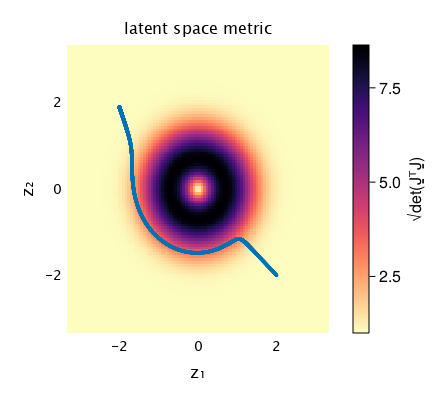

In [35]:
# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add optimized curve
scatterlines!(ax_input, eachrow(γ)..., markersize=5)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig

Although it is not the "true" geodesic we obtained by integrating the
boundary-value problem, this is a very decent approximation!

Let's benchmark this solution.

In [34]:
BenchmarkTools.@benchmark min_energy_spline(γ_init, γ_end, f̲, n_points; tol=1E-2)

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  192.797 ms … 223.459 ms  ┊ GC (min … max): 0.00% … 10.98%
 Time  (median):     195.542 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   200.936 ms ±  10.723 ms  ┊ GC (mean ± σ):  2.45% ±  4.53%

  ▁▁ ██                                                       ▁  
  ██▁██▆▆▆▁▆▆▁▆▆▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▆▁▆▁▁▁█ ▁
  193 ms           Histogram: frequency by time          223 ms <

 Memory estimate: 64.29 MiB, allocs estimate: 1857665.